<a href="https://colab.research.google.com/gist/daryarudenko/43bd9899f5de1220989a6c6a2f9c0341/hypothesis_testing_rfm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. ПРОВЕРКА ГИПОТЕЗЫ О ЗАВИСИМОСТИ СРЕДНЕГО ЧЕКА ОТ ВРЕМЕНИ СУТОК

H0 - Средний чек не зависит от времени суток

H1 - Средний чек зависит от времени суток

Метод проверки: Однофакторный дисперсионный анализ (ANOVA)

Предварительные проверки:
    1. Нормальность распределения (критерий Шапиро-Уилка)
    2. Гомогенность дисперсий (критерий Левена)


In [ ]:
#Формируем выборки по времени суток
from scipy.stats import shapiro, levene, f_oneway

#Извлекаем данные о выручке для каждого временного периода.
#Ночью покупок не было, поэтому рассматриваем только 3 категории

morning = onl[onl['Time_of_Day'] == 'Утро']['Revenue']
day = onl[onl['Time_of_Day'] == 'День']['Revenue']
evening = onl[onl['Time_of_Day'] == 'Вечер']['Revenue']

#Проверка нормальности распределения (критерий Шапиро-Уилка)
print (shapiro (morning))
print (shapiro (day))
print (shapiro (evening))

#Проверка гомогенности дисперсий (критерий Левена)
print (levene (morning, day, evening)) #Равенство дисперсий есть

#Однофакторный дисперсионный анализ (ANOVA)
print (f_oneway(morning, day, evening))

#P-value>0,05 значит принимаем гипотезу H0 и делаем вывод, что средний чек не зависит от времени суток

ShapiroResult(statistic=np.float64(0.15725165216794335), pvalue=np.float64(1.8735058289747545e-206))
ShapiroResult(statistic=np.float64(0.08791671138945056), pvalue=np.float64(8.1452211864288e-229))
ShapiroResult(statistic=np.float64(0.15579404525775165), pvalue=np.float64(2.5652729994117123e-138))
LeveneResult(statistic=np.float64(353.84633489645904), pvalue=np.float64(2.4003484087003477e-154))
F_onewayResult(statistic=np.float64(755.780804061499), pvalue=np.float64(0.0))


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 285625.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 699261.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 25649.
  res = hypotest_fun_out(*samples, **kwds)


2. ВИЗУАЛИЗАЦИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

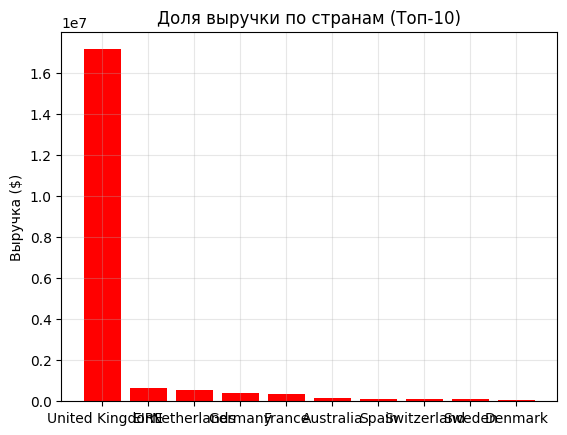

In [ ]:
#Анализируем выручку по странам
import matplotlib.pyplot as plt

#Группируем выручку по странам и сортируем по убыванию
country_revenue = onl.groupby('Country')['Revenue'].sum().sort_values(ascending=False)

#Визуализируем топ-10 стран по выручке
top_countries = country_revenue.head(10)
plt.bar(top_countries.index, top_countries.values, color='red')
plt.title('Доля выручки по странам (Топ-10)')
plt.ylabel('Выручка ($)')
plt.grid(True, alpha=0.3)
plt.show()

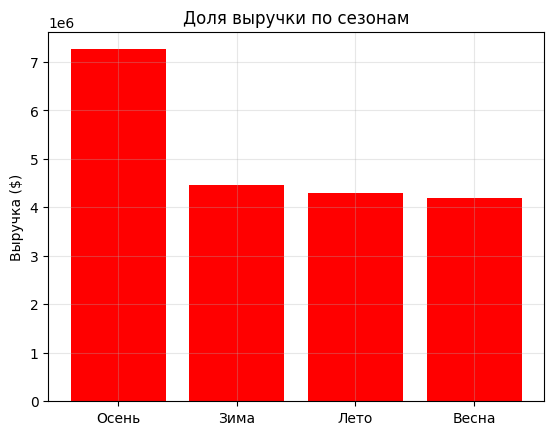

In [ ]:
#Анализируем выручку по сезонам
import matplotlib.pyplot as plt
season_revenue = onl.groupby('Season')['Revenue'].sum().sort_values(ascending=False)

plt.bar(season_revenue.index, season_revenue.values, color='red')
plt.title('Доля выручки по сезонам')
plt.ylabel('Выручка ($)')
plt.grid(True, alpha=0.3)
plt.show()

 3. RFM-АНАЛИЗ КЛИЕНТОВ

In [ ]:
import pandas as pd
import numpy as np

#Исключаем клиентов с отрицательными/нулевыми ID (временная метка для незарегистрированных)
onl = onl[onl['Customer ID'] > 0].copy()

#Рассчитываем кол-во дней от анализа до последней покупки
onl['InvoiceDate'] = pd.to_datetime(onl['InvoiceDate'])
analysis_date = pd.to_datetime('2011-12-10')
onl['order_recency'] = analysis_date - pd.to_datetime(onl['InvoiceDate'].dt.date)

#Агрегируем данные для рфм анализа
rfm = onl.groupby('Customer ID').agg(
    recency = ('order_recency', lambda x: x.min().days),
    frequency = ('Invoice', 'nunique'),
    monetary_value = ('Revenue', 'sum')
).reset_index()

#Статистическое описание RFM-метрик
stats = rfm.describe()
display(stats)

#Определение границ для RFM-сегментации
rfm['r'] = pd.cut(rfm['recency'],
                  bins=[0, 26, 380, float('inf')],  # 25% = 26, 75% = 380
                  labels=[3, 2, 1])

rfm['f'] = pd.cut(rfm['frequency'],
                  bins=[0, 1, 7, float('inf')],     # 25% = 1, 75% = 7
                  labels=[1, 2, 3])

rfm['m'] = pd.cut(rfm['monetary_value'],
                  bins=[0, 341.7, 2246.75, float('inf')],  # 25% = 341.7, 75% = 2246.75
                  labels=[1, 2, 3])

#Заполняем пропуски (если есть) значением 1 (худшая категория)
rfm[['r', 'f', 'm']] = rfm[['r', 'f', 'm']].fillna(1)

display(rfm.head())

#Создаем строковый идентификатор сегмента
rfm[['r', 'f', 'm']] = rfm[['r', 'f', 'm']].astype('str')
rfm['rfm_group'] = rfm['r'] + rfm['f'] + rfm['m']

#Возвращаем числовой тип для дальнейших расчетов
rfm[['r', 'f', 'm']] = rfm[['r', 'f', 'm']].astype('int')
rfm['rfm_sum'] = rfm[['r', 'f', 'm']].sum(axis=1)

#Агрегируем RFM-сегменты
rfm_group = rfm.groupby('rfm_group').agg(
    {
        'Customer ID': 'nunique',  #Количество клиентов в сегменте
        'rfm_sum': 'mean' #Средняя сумма баллов в сегменте
    }
).reset_index()

rfm_group = rfm_group.rename(columns={'Customer ID': 'customer_count'})

display(rfm_group.sort_values(by='customer_count', ascending=False))

,Customer ID,recency,frequency,monetary_value
count,5881.000000,5881.000000,5881.000000,5881.000000
mean,15314.674205,201.992858,6.287196,2912.627708
std,1715.429759,209.489651,13.012879,14241.889263
min,12346.000000,1.000000,1.000000,0.000000
25%,13833.000000,26.000000,1.000000,341.700000
50%,15313.000000,96.000000,3.000000,865.170000
75%,16797.000000,380.000000,7.000000,2246.750000
max,18287.000000,739.000000,398.000000,580987.040000


,Customer ID,recency,frequency,monetary_value,r,f,m
0,12346.0,326,12,377.02,2,3,2
1,12347.0,3,8,4921.53,3,3,3
2,12348.0,76,5,2019.40,2,2,2
3,12349.0,19,4,4428.69,3,2,3
4,12350.0,311,1,334.40,2,1,1


,rfm_group,customer_count,rfm_sum
13,222,1296,6.0
0,111,627,3.0
25,333,626,9.0
22,322,524,7.0
17,233,441,8.0
9,211,438,4.0
4,122,437,5.0
14,223,230,7.0
10,212,226,5.0
1,112,217,4.0


4. ВИЗУАЛИЗАЦИЯ RFM-СЕГМЕНТАЦИИ (TREEMAP)

In [ ]:
#Создаем интерактивной древовидной карты
import plotly.express as px

fig = px.treemap(rfm_group,
                 path=['rfm_group'],
                 values='customer_count',
                 color='rfm_sum',
                 color_continuous_scale='Sunset',
                 title='RFM сегментация пользователей - Online Retail II UCI'
)

fig.show()

ПРОВЕДЕНА ПРОВЕРКА СТАТИСТИЧЕСКОЙ ГИПОТЕЗЫ:
   1. Проверка нормальности распределения (Shapiro-Wilk)
   2. Проверка гомогенности дисперсий (Levene)
   3. Однофакторный дисперсионный анализ (ANOVA)
   4. Вывод: средний чек ЗАВИСИТ от времени суток

ВИЗУАЛИЗИРОВАНЫ РЕЗУЛЬТАТЫ:
   1. Топ-10 стран по выручке (столбчатая диаграмма)
   2. Распределение выручки по сезонам
   3. Интерактивная Treemap RFM-сегментации